In [1]:
import pandas as pd
from transformers import pipeline
from datetime import datetime
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from bidi.algorithm import get_display
import re
import nltk
from nltk.corpus import stopwords
import matplotlib as mpl
from collections import Counter
import datetime
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_notebook
from bokeh.models import DatetimeTickFormatter

# Download the Hebrew stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

C:\Users\U-5058\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\U-5058\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\U-5058\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [140]:
#Loading pretrainedmodel from hugging face#
MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

In [3]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

def sentiment_classifier(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return scores

def preprocess_data(tweets_df):
    # Convert TweetDate column to datetime format
    tweets_df['tweetDate'] = tweets_df['tweetDate'].apply(lambda x : datetime.strptime(x, '%a %b %d %H:%M:%S +0000 %Y'))
    tweets_df['tweetDate'] = pd.to_datetime(tweets_df['tweetDate'], format='%Y-%m-%d %H:%M:%S')
    # Add a new column to store the date of each tweet
    tweets_df['Date'] = tweets_df['tweetDate'].dt.date

# Function to clean the text by removing URLs and usernames
def preprocess_data_text(text):
    # Get the Hebrew stopwords
    hebrew_stopwords = set(stopwords.words('hebrew'))
    hebrew_stopwords.add('זו')
    hebrew_stopwords.add('ב')
    hebrew_stopwords.add('ה')
    
   # Step 1: Filtering non-standard lexical tokens
    url_pattern = r"http\S+"
    username_pattern = r"@\w+"
    hashtags_pattern = r"#\w+"
    unconventional_punctuation_pattern = r"[^\w\s]"
    
    # Remove URLs
    cleaned_text = re.sub(url_pattern, "", text)
    # Remove usernames
    cleaned_text = re.sub(username_pattern, "", cleaned_text)
    # Remove hashtags 
    cleaned_text = re.sub(hashtags_pattern, "", cleaned_text)
    # Remove unconventional punctuation
    cleaned_text = re.sub(unconventional_punctuation_pattern, "", cleaned_text)
    
    # Step 2: Eliminating duplicate tweets and retweets
    #cleaned_text = list(set(cleaned_text))
    
    # Step 3: Removing standard stop words
    cleaned_text = ' '.join([word for word in nltk.word_tokenize(cleaned_text) if word.lower() not in hebrew_stopwords])
    
    # Remove non-Hebrew characters
    cleaned_text = re.sub(r"[^\u0590-\u05FF\s]+", "", cleaned_text)
    # Remove consecutive whitespace characters
    cleaned_text = re.sub(r"\s+", " ", cleaned_text)
    # Trim leading/trailing whitespace
    cleaned_text = cleaned_text.strip()
    
    return cleaned_text

def remove_empty_tweets(df):
    # Drop rows where 'Text' column is empty or contains only whitespace
    df = df.dropna(subset=['Text'])
    df = df[df['Text'].str.strip().astype(bool)]

    # Reset the index of the DataFrame
    df = df.reset_index(drop=True)
    return df

def generate_word_cloud(text):
    wordcloud = WordCloud(width = 600, height = 600, 
    background_color ='white', 
    max_words=200, 
    min_font_size = 10,
    font_path='davidbd.ttf').generate(text)
    return wordcloud

def plot_word_cloud(df):
    cleaned_text=list()
    for i,r in df.iterrows():
            text=r['Text']
            if isinstance(text, str):
                bidi_text = get_display(text)
                cleaned_text.append(bidi_text)
    wordcloud = generate_word_cloud(''.join(cleaned_text))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def n_gram(df,n):
    
    # Combine all text into a single string
    all_text = ' '.join(df['Text'].values.tolist())
    # Generate n-grams
    ngram_counts = Counter(ngrams(all_text.split(), n))

    # Display most common n-grams
    most_common_ngrams = ngram_counts.most_common(10)
    print(f"Most common {n}-grams:")
    for ngram, count in most_common_ngrams:
        print(f"{' '.join(ngram)}: {count}")
        
def lda_topic(df):   
    # Create a list of tokenized texts
    tokenized_texts = [text.split() for text in df['Text'].values]

    # Create a dictionary of all unique words
    dictionary = corpora.Dictionary(tokenized_texts)

    # Convert tokenized texts to bag-of-words representation
    corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_texts]

    # Apply LDA model
    lda_model = models.LdaModel(corpus, num_topics=3, id2word=dictionary)

    # Display topics and their top words
    print("Topic Modeling (LDA):")
    for idx, topic in lda_model.print_topics(-1):
        print(f"Topic {idx}: {topic}")
        
def most_common(df):
    # Combine all text into a single string
    all_text = ' '.join(df['Text'].values.tolist())

    # Calculate word frequencies
    word_counts = Counter(all_text.split())

    # Display most common words
    most_common_words = word_counts.most_common(10)
    print("Most common words:")
    for word, count in most_common_words:
        print(f"{word}: {count}")

def temporal_analysis(sentiment_df):
    # Convert 'Date' column to datetime
    sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])

    # Group by date and calculate mean sentiment scores
    mean_sentiment_by_date = sentiment_df.groupby(sentiment_df['Date'].dt.date)[['Negative_Score', 'Natural_Score', 'Positive_Score']].mean()

    print("Temporal Analysis:")
    mean_sentiment_by_date['Negative_Score'].plot()
    plt.ylabel('Negative Sentiment Score')
    manager = plt.get_current_fig_manager()
    manager.full_screen_toggle()
    plt.show()
    
def sentiment_score_builder(tweets_df):
    # Create a new DataFrame to store the average sentiment score for each date
    sentiment_df = pd.DataFrame(columns=['Date', 'Text','Negative_Score','Natural_Score','Positive_Score'])

    # Iterate over each date and calculate the average sentiment score for all tweets on that date
    for tweet in tweets_df.iterrows():
        text = tweet[1].Text
        date = tweet[1].Date
        sentiment_score = sentiment_classifier(text)
        sentiment_df = sentiment_df.append({'Date': date,'Text':text,'Negative_Score':sentiment_score[0],'Natural_Score':sentiment_score[1],'Positive_Score':sentiment_score[2]}, ignore_index=True)
    return sentiment_df

def calculate_avarge_rolling(df,column_name,window_size):
    df[column_name+'_Rolling'] = df.rolling(window_size,min_periods=window_size).mean()[column_name]
    df = df.dropna()
    return df

def plot_twittes_by_time(df,column_name,upper_th,lower_th):
    df['AreaSentiment'] = ["red" if score >upper_th else "yellow" if score>lower_th else "green" for score in df[column_name]]

    # Create a ColumnDataSource from the DataFrame
    source = ColumnDataSource(df)
    # Create the figure
    p = figure(title="Twitters Avarage Sentiment Scores  Over Time", x_axis_label="Date", y_axis_label=column_name)

    # Add a scatter plot
    p.scatter("Date", column_name, source=source,color='AreaSentiment')

    # Format the x-axis tick labels
    p.xaxis[0].formatter = DatetimeTickFormatter(months="%Y-%m-%d %H:%M:%S")

    # Add hover tool to display the text when hovering over a data point
    hover = HoverTool(tooltips=[("Text", "@Text"),("Date","@Date{%F}")],formatters={'@Date': 'datetime'})
    p.add_tools(hover)
    # Show the plot
    show(p)

In [466]:
sentiment_raw_data = pd.read_excel("TwittesCombine.xlsx")
sentiment_raw_data.head(5)

,tweetDate,twitterId,handle,text,profileUrl,name,tweetLink,timestamp,query
0,Fri Dec 09 10:15:40 +0000 2022,1.421636e+18,mosaud08,"אשכרה ראש הממשלה שלכם מפגין נגד תוצאות הבחירות והרפורמות שנתניהו מתכנן, ממש כמו הקפיטול. ואז יש כאן ליצנים שמטיפים לי על דמוקרטיה, אצלכם הבחירות זה המלצה? https://t.co/DvyJz3kxOW",https://twitter.com/mosaud08,محمد سعود מוחמד סעוד Mohammed Saud,https://twitter.com/mosaud08/status/1601158631650562048,2023-05-21 17:08:07.270,https://twitter.com/search?q=%20%3A%20min_faves%3A100%20%D7%93%D7%9E%D7%95%D7%A7%D7%A8%D7%98%D7%99%D7%94%20until%3A2022-12-10%20since%3A2022-12-01&src=typed_query&f=live
1,Tue Dec 06 18:13:36 +0000 2022,1.113447e+18,AnatiRina,"9/ מדובר בשאלות רטוריות לחלוטין. חוק יסוד כבוד האדם וחרותו הוא חלק מהחוקה של מדינת ישראל כמדינה דמוקרטית, ובניגוד למה שטאוב טוען דמוקרטיה איננה רק ""ביטוי של רצון האזרחים"" אלא היא הגנה על זכויות אדם מפני עריצות השלטון, היא הגנה מפני עריצות הרוב ואיננה יכולה להתקיים בלעדיה.",https://twitter.com/AnatiRina,Rina Anati,https://twitter.com/AnatiRina/status/1600191743240024064,2023-05-21 17:08:07.270,https://twitter.com/search?q=%20%3A%20min_faves%3A100%20%D7%93%D7%9E%D7%95%D7%A7%D7%A8%D7%98%D7%99%D7%94%20until%3A2022-12-10%20since%3A2022-12-01&src=typed_query&f=live
2,Wed Dec 07 06:57:05 +0000 2022,3.182426e+09,IsraelGaley,"עו""ד ציון אמיר ל@sharongal על דברי יו""ר לשכת עורכי הדין שקרא 'לצאת לרחובות': ""מדברים על דמוקרטיה כאילו לא היתה הכרעה לפני חודש ימים בציבור הישראלי, שהלך להצביע בדיוק על הדברים האלה של רפורמות במערכת המשפט. זה מסע חנופה בלתי נגמר.\n\nשרון גל: ""אבי חימי בחר שלא להתראיין""",https://twitter.com/IsraelGaley,גלי ישראל,https://twitter.com/IsraelGaley/status/1600383878719426560,2023-05-21 17:08:07.270,https://twitter.com/search?q=%20%3A%20min_faves%3A100%20%D7%93%D7%9E%D7%95%D7%A7%D7%A8%D7%98%D7%99%D7%94%20until%3A2022-12-10%20since%3A2022-12-01&src=typed_query&f=live
3,Mon Dec 05 10:35:46 +0000 2022,9.981974e+17,OmerArvili,תודה לכל עובדי עירית ירושלים (כולל זאת ששפכה מים) שיצאו היום מהמשרד כדי לקלל את הפעילים שהפגינו מחוץ לבית המשפט בו התקיים דיון בנוגע לאדמות שמנסים לגזול מתושבי סילוואן. אין על הסיוע שלכם בלהראות לעולם למה ישראל היא לא דמוקרטיה.,https://twitter.com/OmerArvili,Omer Arvili,https://twitter.com/OmerArvili/status/1599714138581630976,2023-05-21 17:08:07.270,https://twitter.com/search?q=%20%3A%20min_faves%3A100%20%D7%93%D7%9E%D7%95%D7%A7%D7%A8%D7%98%D7%99%D7%94%20until%3A2022-12-10%20since%3A2022-12-01&src=typed_query&f=live
4,Mon Dec 05 19:55:40 +0000 2022,8.764084e+17,YairNetanyahu,"שמים סוף לטרור המשפטי נגד אזרחי הימין של ישראל! בתקופה האחרונה התפתחה תופעה הזויה אצל השמאל בישראל, כאשר הם משתיקים, מפחידים ומרוששים אזרחים ימנים, באמצעות תביעות השתקה הזויות וחסרות כל בסיס. \nהתופעה הזאת היא סכנה חמורה ביותר לחופש הביטוי בישראל, שבלעדיו אין דמוקרטיה. &gt;&gt; https://t.co/g4EYBidOsg",https://twitter.com/YairNetanyahu,Yair Netanyahu,https://twitter.com/YairNetanyahu/status/1599855040797155328,2023-05-21 17:08:07.270,https://twitter.com/search?q=%20%3A%20min_faves%3A100%20%D7%93%D7%9E%D7%95%D7%A7%D7%A8%D7%98%D7%99%D7%94%20until%3A2022-12-10%20since%3A2022-12-01&src=typed_query&f=live


In [467]:
pd.set_option('display.max_colwidth', None)
sentiment_raw_data['Preprocessed_Text'] = sentiment_raw_data['text'].apply(preprocess_data_text)
sentiment_raw_data[['Preprocessed_Text','text']].head(5)

,Preprocessed_Text,text
0,אשכרה ראש הממשלה מפגין תוצאות הבחירות והרפורמות שנתניהו מתכנן ממש הקפיטול ואז ליצנים שמטיפים דמוקרטיה אצלכם הבחירות המלצה,"אשכרה ראש הממשלה שלכם מפגין נגד תוצאות הבחירות והרפורמות שנתניהו מתכנן, ממש כמו הקפיטול. ואז יש כאן ליצנים שמטיפים לי על דמוקרטיה, אצלכם הבחירות זה המלצה? https://t.co/DvyJz3kxOW"
1,מדובר בשאלות רטוריות לחלוטין חוק יסוד כבוד האדם וחרותו חלק מהחוקה מדינת ישראל כמדינה דמוקרטית ובניגוד שטאוב טוען דמוקרטיה איננה ביטוי רצון האזרחים אלא הגנה זכויות אדם מפני עריצות השלטון הגנה מפני עריצות הרוב ואיננה להתקיים בלעדיה,"9/ מדובר בשאלות רטוריות לחלוטין. חוק יסוד כבוד האדם וחרותו הוא חלק מהחוקה של מדינת ישראל כמדינה דמוקרטית, ובניגוד למה שטאוב טוען דמוקרטיה איננה רק ""ביטוי של רצון האזרחים"" אלא היא הגנה על זכויות אדם מפני עריצות השלטון, היא הגנה מפני עריצות הרוב ואיננה יכולה להתקיים בלעדיה."
2,עוד ציון אמיר ל דברי יור לשכת עורכי הדין שקרא לצאת לרחובות מדברים דמוקרטיה כאילו הכרעה חודש ימים בציבור הישראלי שהלך להצביע בדיוק הדברים האלה רפורמות במערכת המשפט מסע חנופה בלתי נגמר שרון גל אבי חימי בחר שלא להתראיין,"עו""ד ציון אמיר ל@sharongal על דברי יו""ר לשכת עורכי הדין שקרא 'לצאת לרחובות': ""מדברים על דמוקרטיה כאילו לא היתה הכרעה לפני חודש ימים בציבור הישראלי, שהלך להצביע בדיוק על הדברים האלה של רפורמות במערכת המשפט. זה מסע חנופה בלתי נגמר.\n\nשרון גל: ""אבי חימי בחר שלא להתראיין"""
3,תודה לכל עובדי עירית ירושלים כולל ששפכה מים שיצאו היום מהמשרד כדי לקלל הפעילים שהפגינו לבית המשפט בו התקיים דיון בנוגע לאדמות שמנסים לגזול מתושבי סילוואן הסיוע בלהראות לעולם ישראל דמוקרטיה,תודה לכל עובדי עירית ירושלים (כולל זאת ששפכה מים) שיצאו היום מהמשרד כדי לקלל את הפעילים שהפגינו מחוץ לבית המשפט בו התקיים דיון בנוגע לאדמות שמנסים לגזול מתושבי סילוואן. אין על הסיוע שלכם בלהראות לעולם למה ישראל היא לא דמוקרטיה.
4,שמים סוף לטרור המשפטי אזרחי הימין ישראל בתקופה האחרונה התפתחה תופעה הזויה השמאל בישראל משתיקים מפחידים ומרוששים אזרחים ימנים תביעות השתקה הזויות וחסרות בסיס התופעה הזאת סכנה חמורה ביותר לחופש הביטוי בישראל שבלעדיו דמוקרטיה,"שמים סוף לטרור המשפטי נגד אזרחי הימין של ישראל! בתקופה האחרונה התפתחה תופעה הזויה אצל השמאל בישראל, כאשר הם משתיקים, מפחידים ומרוששים אזרחים ימנים, באמצעות תביעות השתקה הזויות וחסרות כל בסיס. \nהתופעה הזאת היא סכנה חמורה ביותר לחופש הביטוי בישראל, שבלעדיו אין דמוקרטיה. &gt;&gt; https://t.co/g4EYBidOsg"


In [4]:
sentiment_df = pd.read_excel("sentiment_scores_update.xlsx")
sentiment_df['Text'] = sentiment_df['Text'].apply(preprocess_data_text)
sentiment_df = remove_empty_tweets(sentiment_df)
sentiment_df = sentiment_df[sentiment_df['Date']>'2022-01-22 18:45:39']
sentiment_df.head(5)

,Date,Text,Negative_Score,Natural_Score,Positive_Score
2,2022-10-01 02:10:13,יודע נזכרתי בזה פתאום זוכרים שבמדינה דמוקרטית ...,0.491700,0.294873,0.213427
3,2022-10-01 07:05:56,בתיאום מופלא הליכוד החליט להישאר בבית להרוס מב...,0.600573,0.191813,0.207615
4,2022-10-01 17:41:03,אזהרה אמריקאית בדיחה ברק רביד התועמלן נשלח אתר...,0.891799,0.087368,0.020833
5,2022-10-02 02:58:11,שניתן להבין מהטוויטר הימים האחרונים אם גוש השח...,0.507878,0.357376,0.134746
6,2022-10-02 05:26:56,איש התקשורת שבמקרה מצא כסא ראש הממשלה אוהב ציט...,0.302301,0.362424,0.335275


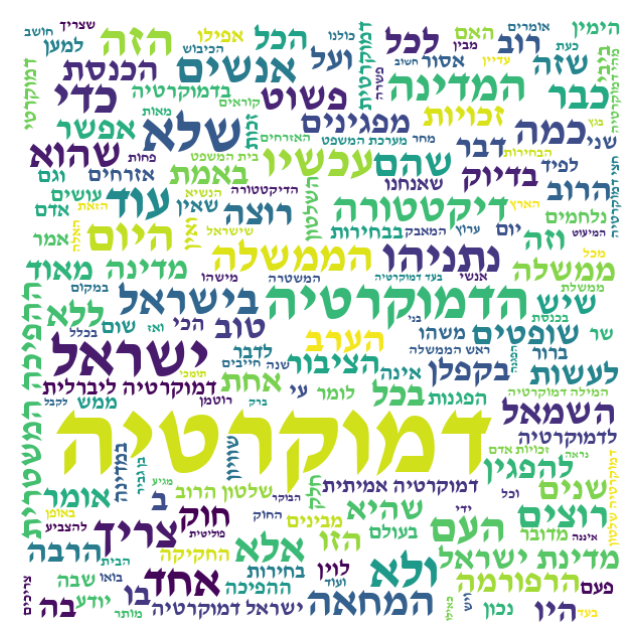

Most common words:
דמוקרטיה: 2176
ישראל: 412
הדמוקרטיה: 217
שלא: 183
הממשלה: 147
עוד: 145
אחד: 144
נתניהו: 143
ולא: 142
עכשיו: 140
Most common 2-grams:
ישראל דמוקרטיה: 56
מדינת ישראל: 48
ההפיכה המשטרית: 46
דמוקרטיה ליברלית: 45
שלטון הרוב: 40
דמוקרטיה אמיתית: 39
דמוקרטיה שלטון: 36
מערכת המשפט: 36
המילה דמוקרטיה: 34
דמוקרטיה מרד: 33


In [470]:
plot_word_cloud(sentiment_df)
most_common(sentiment_df)
n_gram(sentiment_df,2)

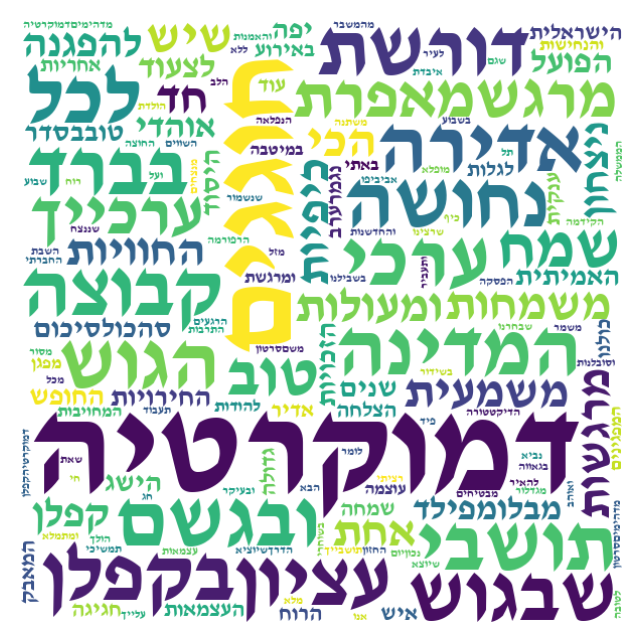

Most common words:
דמוקרטיה: 9
חוגגים: 5
טוב: 3
קפלן: 2
אדירה: 2
בקפלן: 2
המדינה: 2
ערכי: 2
לכל: 2
סרטון: 2


,Date,Text,Negative_Score,Natural_Score,Positive_Score
1738,2023-04-01 18:25:42,ולסיכום לצעוד אוהדי הפועל מבלומפילד ניצחון קפלן להפגנה אחת החוויות הכי כיפיות משמחות מרגשות ומעולות שיש חד משמעית,0.019780,0.065801,0.914418
99,2022-11-02 03:35:45,בסדר שנים דמוקרטיה הישג יפה סהכ,0.036338,0.053331,0.910330
1985,2023-04-25 21:55:23,ערב אדיר הצלחה אדירה איש בקפלן באירוע העצמאות המדינה בקפלן שמחה גדולה חגיגה ענקית הרוח הישראלית האמיתית חוגגים דמוקרטיה חוגגים ערכי היסוד המדינה חוגגים הזכויות חוגגים החירויות חוגגים החופש טוב,0.019218,0.071068,0.909714
1647,2023-03-27 11:01:49,דמוקרטיה במיטבה מפגן עוצמה אדירה ומרגשת באתי להודות לכל המפגינים המחויבות והנחישות כולנו לגלות אחריות המאבק עוד נגמר,0.039543,0.053636,0.906821
1402,2023-03-18 22:29:33,סרטון מרגשמאפרת שבגוש עציון בברד ובגשם קבוצה נחושה תושבי הגוש דורשת דמוקרטיה מדהימים,0.025513,0.068844,0.905643


In [473]:
top_positive_tweets = sentiment_df.sort_values(by='Positive_Score',ascending=False).head(10)
plot_word_cloud(top_positive_tweets)
most_common(top_positive_tweets)
top_positive_tweets.head(5)

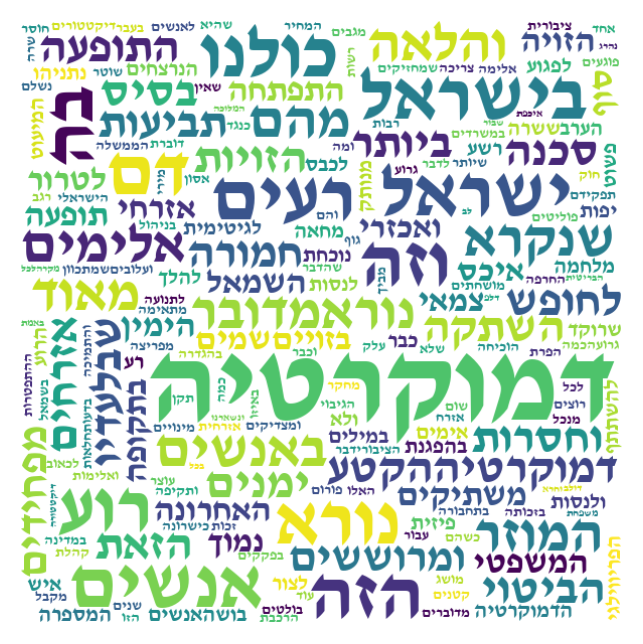

Most common words:
דמוקרטיה: 8
נורא: 3
אנשים: 3
הזה: 2
ישראל: 2
בישראל: 2
רעים: 2
בה: 2
רוע: 2
דם: 2


,Date,Text,Negative_Score,Natural_Score,Positive_Score
953,2023-02-25 21:42:04,מדובר באנשים אלימים מאוד דמוקרטיה מהם והלאה,0.960989,0.026489,0.012522
254,2022-12-11 02:45:44,הקטע המוזר הזה שנקרא דמוקרטיה נורא,0.957627,0.030681,0.011691
238,2022-12-05 19:55:40,שמים סוף לטרור המשפטי אזרחי הימין ישראל בתקופה האחרונה התפתחה תופעה הזויה השמאל בישראל משתיקים מפחידים ומרוששים אזרחים ימנים תביעות השתקה הזויות וחסרות בסיס התופעה הזאת סכנה חמורה ביותר לחופש הביטוי בישראל שבלעדיו דמוקרטיה,0.957620,0.031260,0.011120
1015,2023-03-01 20:27:11,אנשים רעים פשוט רעים כבר לכבס הרוע במילים יפות דמוקרטיה לצור המספרה ששרה נתניהו נוכחת בה לנסות להלך אימים ולנסות לפגוע בה פיזית מחאה לגיטימית ולא מלחמה הדמוקרטיה רוע רוע נמוך ואכזרי אנשים צמאי דם איכס בזויים,0.957487,0.030583,0.011930
591,2023-01-28 15:59:27,שמתכוון להשתתף בהפגנת המיעוט הפריווילגי הערב איש רע רשע מנותק שרוקד דם הנרצחים בושה,0.954890,0.031673,0.013438


In [474]:
top_negative_tweets = sentiment_df.sort_values(by='Negative_Score',ascending=False).head(10)
plot_word_cloud(top_negative_tweets)
most_common(top_negative_tweets)
top_negative_tweets.head(5)

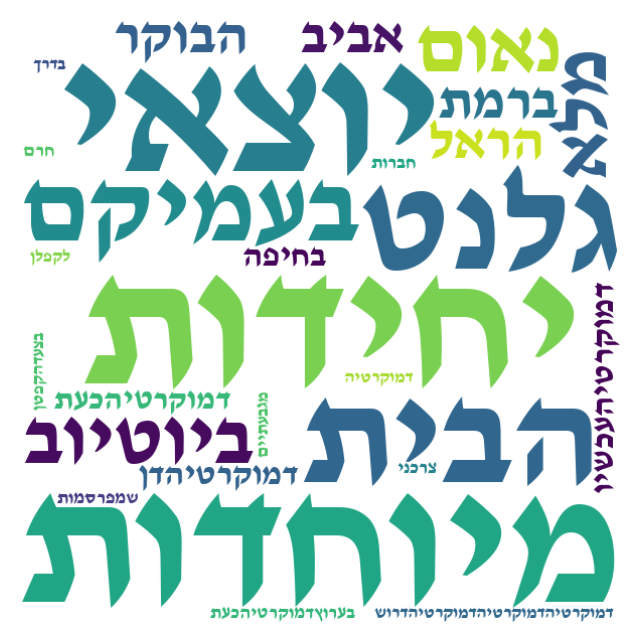

Most common words:
דמוקרטיה: 8
כעת: 2
בעמיקם: 2
הבית: 2
גלנט: 2
יוצאי: 2
יחידות: 2
מיוחדות: 2
דן: 1
הראל: 1


,Date,Text,Negative_Score,Natural_Score,Positive_Score
1002,2023-03-01 08:53:30,דן הראל ברמת אביב הבוקר נאום מלא ביוטיוב,0.018014,0.909836,0.072151
1860,2023-04-15 17:38:13,עכשיו בחיפה דמוקרטיה,0.025376,0.896831,0.077793
1375,2023-03-18 15:52:49,כעת בעמיקם הבית גלנט יוצאי יחידות מיוחדות דמוקרטיה,0.053080,0.862510,0.084410
1376,2023-03-18 15:52:49,כעת בעמיקם הבית גלנט יוצאי יחידות מיוחדות דמוקרטיה,0.053080,0.862510,0.084410
50,2022-10-13 06:46:25,דמוקרטיה,0.090624,0.858357,0.051019


In [475]:
top_netural_tweets = sentiment_df.sort_values(by='Natural_Score',ascending=False).head(10)
plot_word_cloud(top_netural_tweets)
most_common(top_netural_tweets)
top_netural_tweets.head(5)

In [477]:
lda_topic(sentiment_df)

Topic Modeling (LDA):
Topic 0: 0.020*"דמוקרטיה" + 0.004*"הממשלה" + 0.003*"עוד" + 0.003*"דיקטטורה" + 0.003*"ישראל" + 0.002*"ולא" + 0.002*"שלא" + 0.002*"נתניהו" + 0.002*"אחד" + 0.002*"לכולם"
Topic 1: 0.027*"דמוקרטיה" + 0.005*"ישראל" + 0.004*"הממשלה" + 0.004*"הזה" + 0.003*"המדינה" + 0.003*"אחד" + 0.003*"הדמוקרטיה" + 0.002*"שלא" + 0.002*"נתניהו" + 0.002*"המחאה"
Topic 2: 0.033*"דמוקרטיה" + 0.007*"ישראל" + 0.004*"המחאה" + 0.004*"בקפלן" + 0.004*"הערב" + 0.004*"עכשיו" + 0.003*"היום" + 0.003*"למען" + 0.003*"ההפיכה" + 0.003*"עוד"


In [478]:
n_gram(sentiment_df,3)

Most common 3-grams:
דמוקרטיה שלטון הרוב: 25
שלטון הרוב דמוקרטיה: 15
הרוב דמוקרטיה שלטון: 15
ישראל תישאר דמוקרטיה: 13
בית המשפט העליון: 12
דמוקרטיה מדינת ישראל: 10
ישראל הייתה דמוקרטיה: 7
דמוקרטיה נגמרת בבחירות: 7
ישראל דמוקרטיה ישראל: 7
דבר חצי דמוקרטיה: 7


Temporal Analysis:


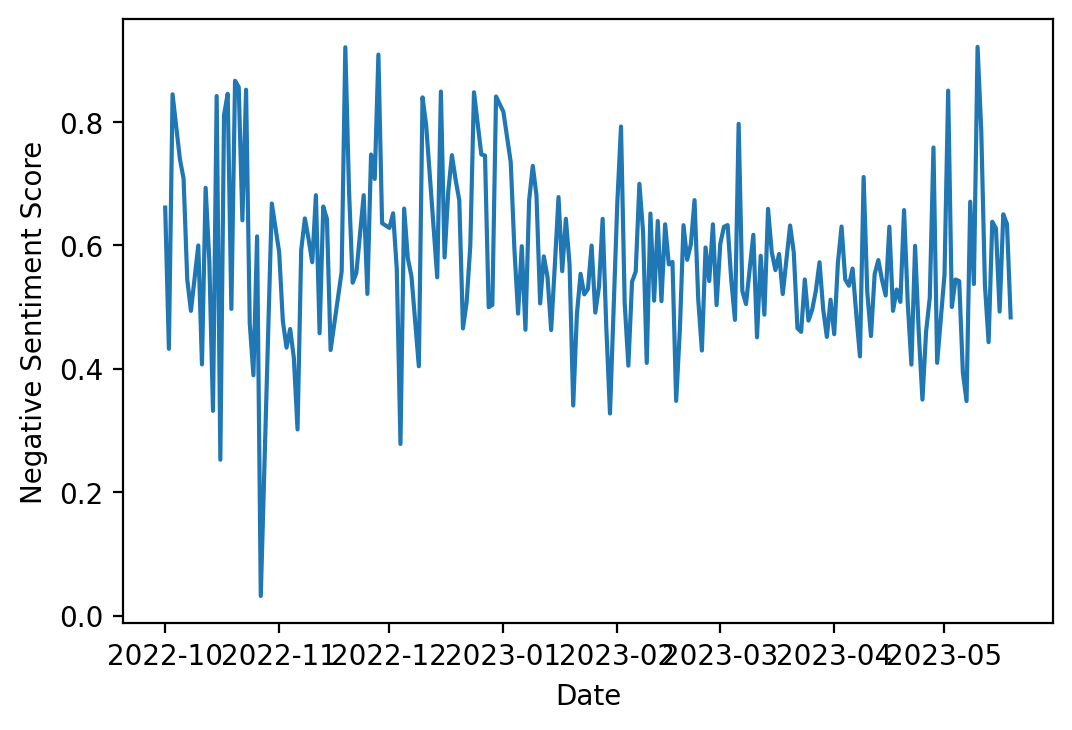

In [479]:
mpl.rcParams['figure.dpi'] = 200
temporal_analysis(sentiment_df)

In [5]:
sentiment_df = calculate_avarge_rolling(sentiment_df,'Negative_Score',250)
sentiment_df.head(5)

,Date,Text,Negative_Score,Natural_Score,Positive_Score,Negative_Score_Rolling
251,2022-12-09 10:15:40,אשכרה ראש הממשלה מפגין תוצאות הבחירות והרפורמו...,0.768007,0.172078,0.059915,0.581288
252,2022-12-10 07:12:39,שניצחו בבחירות ורוצים להקים ממשלת זוועות חושבי...,0.842283,0.114865,0.042852,0.582690
253,2022-12-10 23:28:13,די להחליף מסכות פשוט תקראו לילד בשמו מפלגת הקר...,0.837626,0.122697,0.039677,0.583638
254,2022-12-11 02:45:44,הקטע המוזר הזה שנקרא דמוקרטיה נורא,0.957627,0.030681,0.011691,0.583902
255,2022-12-11 09:01:48,היהדות דת שום סיבה למדינה יהודית דתות צריכות מ...,0.630902,0.280450,0.088648,0.584394


In [8]:
plot_twittes_by_time(sentiment_df,'Negative_Score_Rolling',0.56,0.52)

Text(0, 0.5, 'Sentiment_Negative_Score')

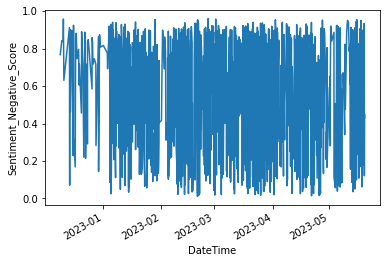

In [9]:
featuers_exploration = sentiment_df[['Date','Negative_Score','Negative_Score_Rolling']]
featuers_exploration.set_index('Date')['Negative_Score'].plot()
plt.xlabel('DateTime')
plt.ylabel('Sentiment_Negative_Score')

<AxesSubplot:xlabel='Date'>

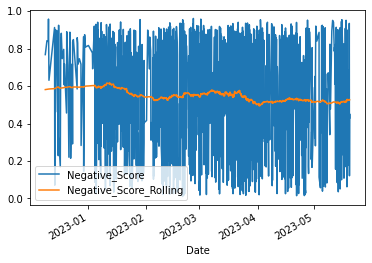

In [10]:
featuers_exploration.set_index('Date').plot()

In [ ]:
sentiment_df['Date']=sentiment_df['Date'].dt.date
date_count_series = sentiment_df['Date'].value_counts()
date_count_df = pd.DataFrame({'date':date_count_series.index, 'count':date_count_series.values})
date_count_df = date_count_df.sort_values(by='date')
date_count_df = date_count_df[date_count_df['date']>pd.to_datetime('2022-10-01')]

Text(0, 0.5, 'DateTime')

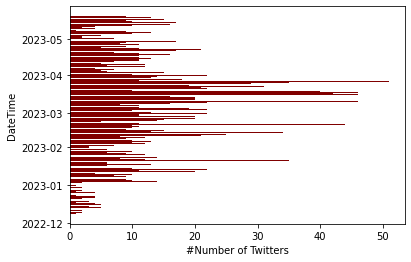

In [14]:
# creating the bar plot
date_count_df = date_count_df[date_count_df['date']>pd.to_datetime('2022-10-01')]
plt.barh(date_count_df['date'], date_count_df['count'], color ='maroon')
plt.xlabel('#Number of Twitters')
plt.ylabel('DateTime')